In [6]:
import os
import random
import numpy as np
import gymnasium as gym
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.autograd as autograd
import torch.optim.lr_scheduler as lr_scheduler
from torch.autograd import Variable
from collections import deque, namedtuple

In [ ]:
# Não esquecer este import muito importante, de preferência usar no terminal
# pip install Box2D

In [ ]:
# ! pip install swig
# ! pip install gymnasium
# ! pip install gymnasium[box2d]

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com

  DEPRECATION: Building 'box2d-py' using the legacy setup.py bdist_wheel mechanism, which will be removed in a future version. pip 25.3 will enforce this behaviour change. A possible replacement is to use the standardized build interface by setting the `--use-pep517` option, (possibly combined with `--no-build-isolation`), or adding a `pyproject.toml` file to the source tree of 'box2d-py'. Discussion can be found at https://github.com/pypa/pip/issues/6334
  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> [28 lines of output]
      Using setuptools (version 75.2.0).
      C:\Users\ruben\.conda\envs\DM2425\Lib\site-packages\setuptools\_distutils\dist.py:261: UserWarning: Unknown distribution option: 'test_suite'
        warnings.warn(msg)
      running bdist_wheel
      running build
      running build_py
      creating build\lib.win-amd64-cpython-312\Box2D
      copying library\Box2D\Box2D.py -> build\lib.win-amd64


  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Running setup.py clean for box2d-py
Failed to build box2d-py


In [8]:
env = gym.make("LunarLander-v3", gravity=-10, continuous=False,
               enable_wind=False, wind_power=15.0, turbulence_power=1.5)

print("Observation space:", env.observation_space)
print("Action space:", env.action_space)



Observation space: Box([ -2.5        -2.5       -10.        -10.         -6.2831855 -10.
  -0.         -0.       ], [ 2.5        2.5       10.        10.         6.2831855 10.
  1.         1.       ], (8,), float32)
Action space: Discrete(4)


In [9]:
state_shape = env.observation_space.shape
state_size = env.observation_space.shape[0]
number_actions = env.action_space.n

In [10]:
print('State shape: ', state_shape)
print('State size: ', state_size)
print('Number of actions: ', number_actions)

State shape:  (8,)
State size:  8
Number of actions:  4


In [11]:

def random_policy(env, state):
    return env.action_space.sample()

state = env.reset()[0]

for counter in range(201):

    env.render()

    #select the action according to the given policy
    action = random_policy(env, state)
    
    #perform the action and store the next state information
    next_state, reward, done, truncated, info = env.step(action)

    if counter % 10 == 0:
        print("Step:", counter, next_state, reward, done, info)
        
env.close()

Step: 0 [-0.01503162  1.4091259  -0.7539985  -0.05297748  0.01523681  0.1294734
  0.          0.        ] 0.44588907462542804 False {}
Step: 10 [-0.09046612  1.3718398  -0.7719255  -0.21751843  0.08608846  0.17917976
  0.          0.        ] 0.32625893130351075 False {}
Step: 20 [-0.16547307  1.3060017  -0.75919354 -0.33309236  0.1280684   0.02446066
  0.          0.        ] -0.40488008810978043 False {}
Step: 30 [-0.2441092   1.223929   -0.78628    -0.45595643  0.13502331 -0.00783441
  0.          0.        ] 0.2908514609812596 False {}
Step: 40 [-0.32334995  1.1116688  -0.805089   -0.57496685  0.14283653  0.05511198
  0.          0.        ] -1.8069130759439804 False {}
Step: 50 [-0.4051953   0.9617013  -0.81794655 -0.7668024   0.1722839   0.05293814
  0.          0.        ] -1.573169363248694 False {}
Step: 60 [-0.49033904  0.7797813  -0.8811143  -0.8292581   0.19148362  0.03293693
  0.          0.        ] 2.355517686488594 False {}
Step: 70 [-0.5800112   0.57227606 -0.89642704 

c:\Users\ruben\.conda\envs\DM2425\Lib\site-packages\gymnasium\envs\box2d\lunar_lander.py:672: UserWarning: WARN: You are calling render method without specifying any render mode. You can specify the render_mode at initialization, e.g. gym.make("LunarLander-v3", render_mode="rgb_array")
  gym.logger.warn(


In [12]:
seed_value = 42

env = gym.make("LunarLander-v3", gravity=-10, continuous=True,
               enable_wind=False, wind_power=15.0, turbulence_power=1.5)
env.reset(seed=seed_value)

state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]
action_low = float(env.action_space.low[0])
action_high = float(env.action_space.high[0])
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [13]:
class Actor(nn.Module):
    def __init__(self, state_dim, action_dim):
        super().__init__()
        self.fc1 = nn.Linear(state_dim, 256)
        self.fc2 = nn.Linear(256, 256)
        self.out = nn.Linear(256, action_dim)

    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        return torch.tanh(self.out(x))  # Output in [-1, 1]

In [14]:
class Critic(nn.Module):
    def __init__(self, state_dim, action_dim):
        super().__init__()
        self.fc1 = nn.Linear(state_dim + action_dim, 256)
        self.fc2 = nn.Linear(256, 256)
        self.out = nn.Linear(256, 1)

    def forward(self, state, action):
        x = torch.cat([state, action], dim=1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.out(x)

In [15]:
class ReplayBuffer:
    def __init__(self, capacity=100000):
        self.buffer = deque(maxlen=capacity)

    def push(self, *args):
        self.buffer.append(tuple(map(np.array, args)))

    def sample(self, batch_size):
        samples = random.sample(self.buffer, batch_size)
        return map(lambda x: torch.FloatTensor(np.vstack(x)).to(device), zip(*samples))

    def __len__(self):
        return len(self.buffer)

In [16]:
class DDPG:
    def __init__(self):
        self.actor = Actor(state_dim, action_dim).to(device)
        self.actor_target = Actor(state_dim, action_dim).to(device)
        self.critic = Critic(state_dim, action_dim).to(device)
        self.critic_target = Critic(state_dim, action_dim).to(device)
        self.actor_target.load_state_dict(self.actor.state_dict())
        self.critic_target.load_state_dict(self.critic.state_dict())

        self.actor_optimizer = optim.Adam(self.actor.parameters(), lr=1e-3)
        self.critic_optimizer = optim.Adam(self.critic.parameters(), lr=1e-2)
        self.memory = ReplayBuffer()
        self.gamma = 0.99
        self.tau = 0.005

    def select_action(self, state, noise=0.1):
        state = torch.FloatTensor(state).unsqueeze(0).to(device)
        action = self.actor(state).detach().cpu().numpy()[0]
        action = action + noise * np.random.randn(action_dim)
        return np.clip(action, action_low, action_high)

    def train(self, batch_size=64):
        if len(self.memory) < batch_size:
            return
        states, actions, rewards, next_states, dones = self.memory.sample(batch_size)

        # Critic loss
        with torch.no_grad():
            next_actions = self.actor_target(next_states)
            target_Q = self.critic_target(next_states, next_actions)
            target_Q = rewards + self.gamma * (1 - dones) * target_Q
        current_Q = self.critic(states, actions)
        critic_loss = F.mse_loss(current_Q, target_Q)

        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        self.critic_optimizer.step()

        # Actor loss
        actor_loss = -self.critic(states, self.actor(states)).mean()
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()

        # Soft update
        for target_param, param in zip(self.critic_target.parameters(), self.critic.parameters()):
            target_param.data.copy_(self.tau * param.data + (1 - self.tau) * target_param.data)
        for target_param, param in zip(self.actor_target.parameters(), self.actor.parameters()):
            target_param.data.copy_(self.tau * param.data + (1 - self.tau) * target_param.data)

In [17]:
agent = DDPG()
episodes = 1000
timesteps = 300
initial_noise = 0.5
final_noise = 0.025
noise_decay = 0.995


In [18]:
for ep in range(episodes):
    state = env.reset()[0]
    episode_reward = 0
    noise = max(final_noise, initial_noise * (noise_decay ** ep))
    for t in range(timesteps):
        action = agent.select_action(state, noise=noise)
        next_state, reward, done, _, _ = env.step(action)
        agent.memory.push(state, action, reward, next_state, float(done))
        agent.train()
        state = next_state
        episode_reward += reward
        if done:
            break
    print(f"Episode {ep+1}, Reward: {episode_reward:.2f}, Noise: {noise:.3f}")

env.close()

Episode 1, Reward: -151.54, Noise: 0.500
Episode 2, Reward: -511.70, Noise: 0.497
Episode 3, Reward: -141.08, Noise: 0.495
Episode 4, Reward: -199.12, Noise: 0.493
Episode 5, Reward: -78.47, Noise: 0.490
Episode 6, Reward: -60.54, Noise: 0.488
Episode 7, Reward: -60.15, Noise: 0.485
Episode 8, Reward: -36.13, Noise: 0.483
Episode 9, Reward: -15.13, Noise: 0.480
Episode 10, Reward: -15.95, Noise: 0.478
Episode 11, Reward: 81.23, Noise: 0.476
Episode 12, Reward: -21.40, Noise: 0.473
Episode 13, Reward: -6.21, Noise: 0.471
Episode 14, Reward: 12.68, Noise: 0.468
Episode 15, Reward: -23.72, Noise: 0.466
Episode 16, Reward: 56.62, Noise: 0.464
Episode 17, Reward: 17.29, Noise: 0.461
Episode 18, Reward: -2.62, Noise: 0.459
Episode 19, Reward: 10.16, Noise: 0.457
Episode 20, Reward: -10.69, Noise: 0.455
Episode 21, Reward: 55.88, Noise: 0.452
Episode 22, Reward: -6.79, Noise: 0.450
Episode 23, Reward: 62.81, Noise: 0.448
Episode 24, Reward: 29.18, Noise: 0.446
Episode 25, Reward: -82.74, Nois

In [19]:
env.close()

In [20]:
render_env = gym.make("LunarLander-v3", gravity=-10, continuous=True,
                      enable_wind=False, wind_power=15.0, turbulence_power=1.5, render_mode='human')
render_env.reset(seed=seed_value)

(array([ 0.00229702,  1.4181306 ,  0.2326471 ,  0.3204666 , -0.00265488,
        -0.05269805,  0.        ,  0.        ], dtype=float32),
 {})

In [21]:
def test_agent(agent, env, episodes=5, max_steps=300):
    for ep in range(episodes):
        state = env.reset()[0]
        done = False
        episode_reward = 0
        step_count = 0
        while not done and step_count < max_steps:
            state_tensor = torch.FloatTensor(state).unsqueeze(0).to(device)
            with torch.no_grad():
                action = agent.actor(state_tensor).cpu().numpy()[0]
            state, reward, done, _, _ = env.step(action)
            episode_reward += reward
            step_count += 1
        print(f"Test Episode {ep+1}, Reward: {episode_reward:.2f}")
    render_env.close()


test_agent(agent, render_env)

Test Episode 1, Reward: 178.26
Test Episode 2, Reward: 227.03
Test Episode 3, Reward: 108.39
Test Episode 4, Reward: 244.62
Test Episode 5, Reward: 244.55


In [22]:
render_env.close()

# PPO

In [23]:
from stable_baselines3 import PPO

In [31]:
# Create PPO model using your existing env
ppo_model = PPO("MlpPolicy", env, verbose=1, tensorboard_log="./ppo_lunar_tensorboard/")

# Train PPO
ppo_model.learn(total_timesteps=1000_000)

# Test/Evaluate PPO agent using your env (with render if you want)
test_env = gym.make("LunarLander-v3", gravity=-10, continuous=False,
               enable_wind=False, wind_power=15.0, turbulence_power=1.5, render_mode='human')
test_env.reset(seed=seed_value)

test_env.close()

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Logging to ./ppo_lunar_tensorboard/PPO_4
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 110      |
|    ep_rew_mean     | -197     |
| time/              |          |
|    fps             | 3223     |
|    iterations      | 1        |
|    time_elapsed    | 0        |
|    total_timesteps | 2048     |
---------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 114          |
|    ep_rew_mean          | -239         |
| time/                   |              |
|    fps                  | 2191         |
|    iterations           | 2            |
|    time_elapsed         | 1            |
|    total_timesteps      | 4096         |
| train/                  |              |
|    approx_kl            | 0.0025116291 |
|    clip_fraction        | 0.00845      |
|    clip

In [32]:
import numpy as np
import matplotlib.pyplot as plt

# Number of evaluation episodes
eval_episodes = 1000
episode_returns = []

for ep in range(eval_episodes):
    obs, _ = env.reset()
    done = False
    total_reward = 0
    steps = 0
    while not done and steps < 300:  # limit steps if you want, to match training
        action, _ = ppo_model.predict(obs, deterministic=True)
        obs, reward, done, truncated, _ = env.step(action)
        total_reward += reward
        steps += 1
        done = done or truncated
    episode_returns.append(total_reward)

avg_return = np.mean(episode_returns)
print(f"Average return over {eval_episodes} eval episodes: {avg_return:.2f}")


Average return over 1000 eval episodes: 148.01


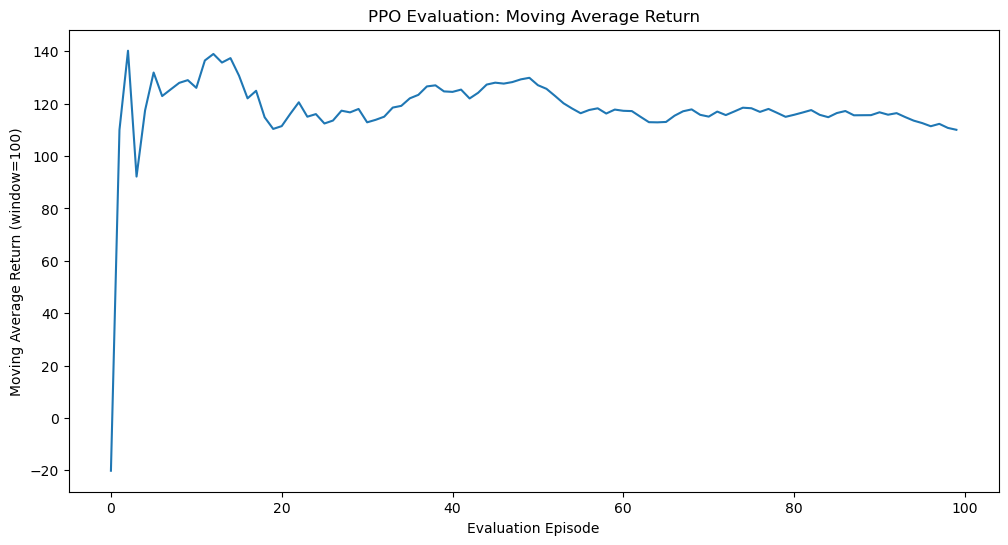

: 

: 

In [ ]:
window = 1000
moving_avg = [np.mean(episode_returns[max(0, i - window):i + 1]) for i in range(len(episode_returns))]

plt.figure(figsize=(12, 6))
plt.plot(moving_avg)
plt.xlabel("Evaluation Episode")
plt.ylabel(f"Moving Average Return (window={window})")
plt.title("PPO Evaluation: Moving Average Return")
plt.show()


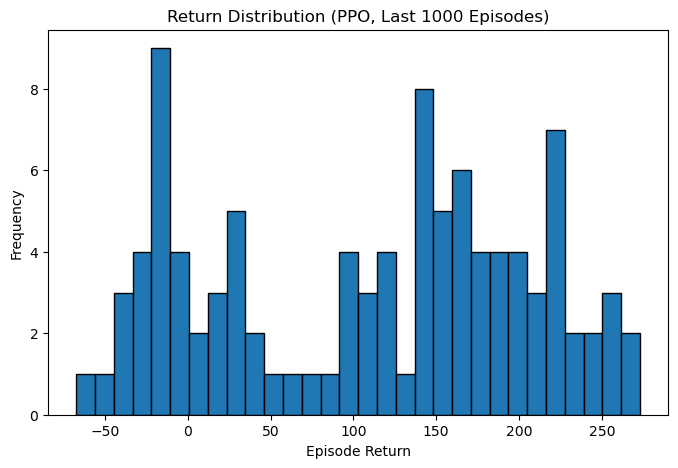

: 

: 

In [ ]:
plt.figure(figsize=(8, 5))
plt.hist(episode_returns, bins=30, edgecolor='k')
plt.xlabel("Episode Return")
plt.ylabel("Frequency")
plt.title("Return Distribution (PPO, Last 1000 Episodes)")
plt.show()


: 

: 